In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:


import os
import time
import skimage
import cv2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, Flatten,GlobalAveragePooling2D
from tqdm import tqdm
from skimage.transform import resize
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping,ModelCheckpoint, Callback
from keras.utils.np_utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.models import Model,load_model
from keras.applications.mobilenet import preprocess_input

earlystopping = EarlyStopping(monitor='val_accuracy', patience=9);

In [3]:

def get_testdata(Dir):
    X = []
    y = []
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            label=getlable(nextdir)
            temp = Dir + nextdir
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (224, 224, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(224, 224, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)

    X = np.asarray(X)
    y = np.asarray(y)
    return X,y


def get_smotedata(Dir):
    X = []
    y = []
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            label = getlable(nextdir)
            temp = Dir + nextdir
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (224, 224, 3))
                    img = np.asarray(img)
                    X.append(img.flatten()) # flatten image array into a 1D array
                    y.append(label)

    X = np.asarray(X)
    y = np.asarray(y)

    # Apply SMOTE to balance class distribution
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # reshape the flattened arrays back into image arrays
    X_resampled = X_resampled.reshape(-1, 224, 224, 3)

    return X_resampled, y_resampled





In [4]:
import numpy as np
# Load X_train and y_train from .npy files
#SMOTE:/kaggle/input/test-train/X_train.npy
#SMOTE:/kaggle/input/test-train/y_train.npy
#X_train = np.load('/kaggle/input/weightsfile/mX_train.npy')
#y_train = np.load('/kaggle/input/weightsfile/my_train.npy')
X_train = np.load('/kaggle/input/test-train/X_train.npy')
y_train = np.load('/kaggle/input/test-train/y_train.npy')
print("train data load")

idx=np.random.permutation(len(X_train))
X_train=X_train[idx]
y_train=y_train[idx]


X_test = np.load('/kaggle/input/test-train/testset/testset/X_test.npy')
y_test = np.load('/kaggle/input/test-train/testset/testset/y_test.npy')
print("test data load")

# Load X_train and y_train from .npy files
#uX_train = np.load('/kaggle/input/test-train/uX_train.npy')
#uy_train = np.load('/kaggle/input/test-train/uy_train.npy')

#idx=np.random.permutation(len(uX_train))
#uX_train=uX_train[idx]
#uy_train=uy_train[idx]
#print("change  data load")


train data load
test data load


In [5]:
leaves_list=['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)', 'carica papaya', 'Carissa Carandas (Karanda)', 'Citrus Limon (Lemon)', 'Ficus Auriculata (Roxburgh fig)', 'Ficus Religiosa (Peepal Tree)', 'Hibiscus Rosa-sinensis', 'Jasminum (Jasmine)', 'Mangifera Indica (Mango)', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Murraya Koenigii (Curry)', 'Nerium Oleander (Oleander)', 'Nyctanthes Arbor-tristis (Parijata)', 'Ocimum Tenuiflorum (Tulsi)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Pongamia Pinnata (Indian Beech)', 'Psidium Guajava (Guava)', 'Punica Granatum (Pomegranate)', 'Santalum Album (Sandalwood)', 'Syzygium Cumini (Jamun)', 'Syzygium Jambos (Rose Apple)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Trigonella Foenum-graecum (Fenugreek)']
def plot_graph(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def confusionmat(model):
  pred = model.predict( X_test)
  pred = np.argmax(pred,axis = 1)
  y_true = np.argmax(y_test,axis = 1)
  CM = confusion_matrix(y_true, pred)
  fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(15, 15))
  plt.show()
  print(classification_report(y_true, pred,target_names=leaves_list))

In [7]:
from tensorflow.keras import regularizers
def mobilenet(X_train, y_train, X_test, y_test, modelname, epoch):
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

    checkpoint_filepath = './Checkpoints/checkpoint_mobilenet'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True)

    base_model = tf.keras.applications.mobilenet.MobileNet(
        input_shape=(224, 224, 3),
       
        depth_multiplier=1,
        dropout=0.9,
        weights='imagenet',
        include_top=False,
        input_tensor=None,
        pooling=None,
        classes=31,
        classifier_activation='softmax'
        
        
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.5))(x)

    x = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.5))(x)

    preds = Dense(31, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=preds)
    #model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    start_time = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch,
                         verbose=1,shuffle=True,callbacks=[earlystopping,model_checkpoint_callback])
    execution_time = (time.time() - start_time) / 60.0
    print("Training execution time (mins)", execution_time)
    plot_graph(history)
    confusionmat(model)

    model.save(modelname)
    # Load the saved model
    model = load_model(modelname)
    return model

from keras.applications.vgg16 import VGG16
def create_Base_model_VGG16(): 
    model = VGG16(weights = "imagenet",include_top=False, input_shape = (224,224,3)) 
    for layer in model.layers:
      layer.trainable = False
    return model 
def my_layers():
    model = create_Base_model_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(31, activation="softmax")(x)   
    # creating the final model 
    final_model = tf.keras.models.Model(inputs = model.input,outputs = predictions)
     
    final_model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])  
    return final_model
def vgg16(X_train, y_train, X_test, y_test, modelname,epoch):
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=9, verbose=1, mode='max', restore_best_weights=True)

    checkpoint_filepath = './Checkpoints/checkpoint_vgg161'
    
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True)
    my_layers().summary()
    model = my_layers()
    start_time = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test , y_test),epochs=epoch, verbose=1,callbacks=[earlystopping,model_checkpoint_callback])
    execution_time = (time.time() - start_time)/60.0
    print("Training execution time (mins)",execution_time)
    plot_graph(history)
    confusionmat(model)
    
    model.save(modelname)
    # Load the saved model
    model = load_model(modelname)
    return model



58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

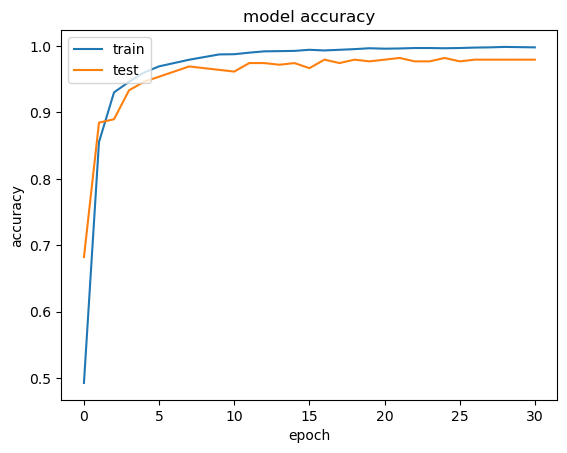

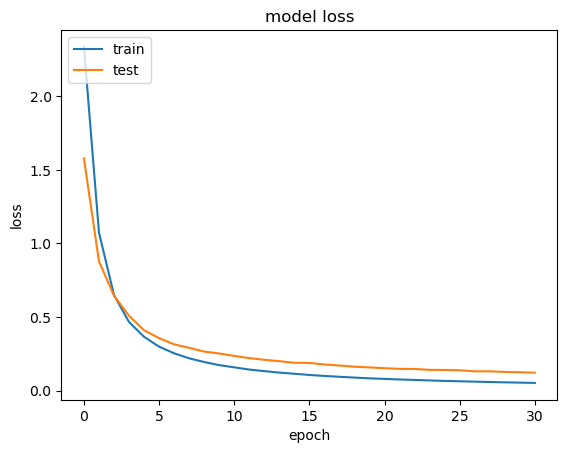

13/13 [==============================] - 1s 70ms/step


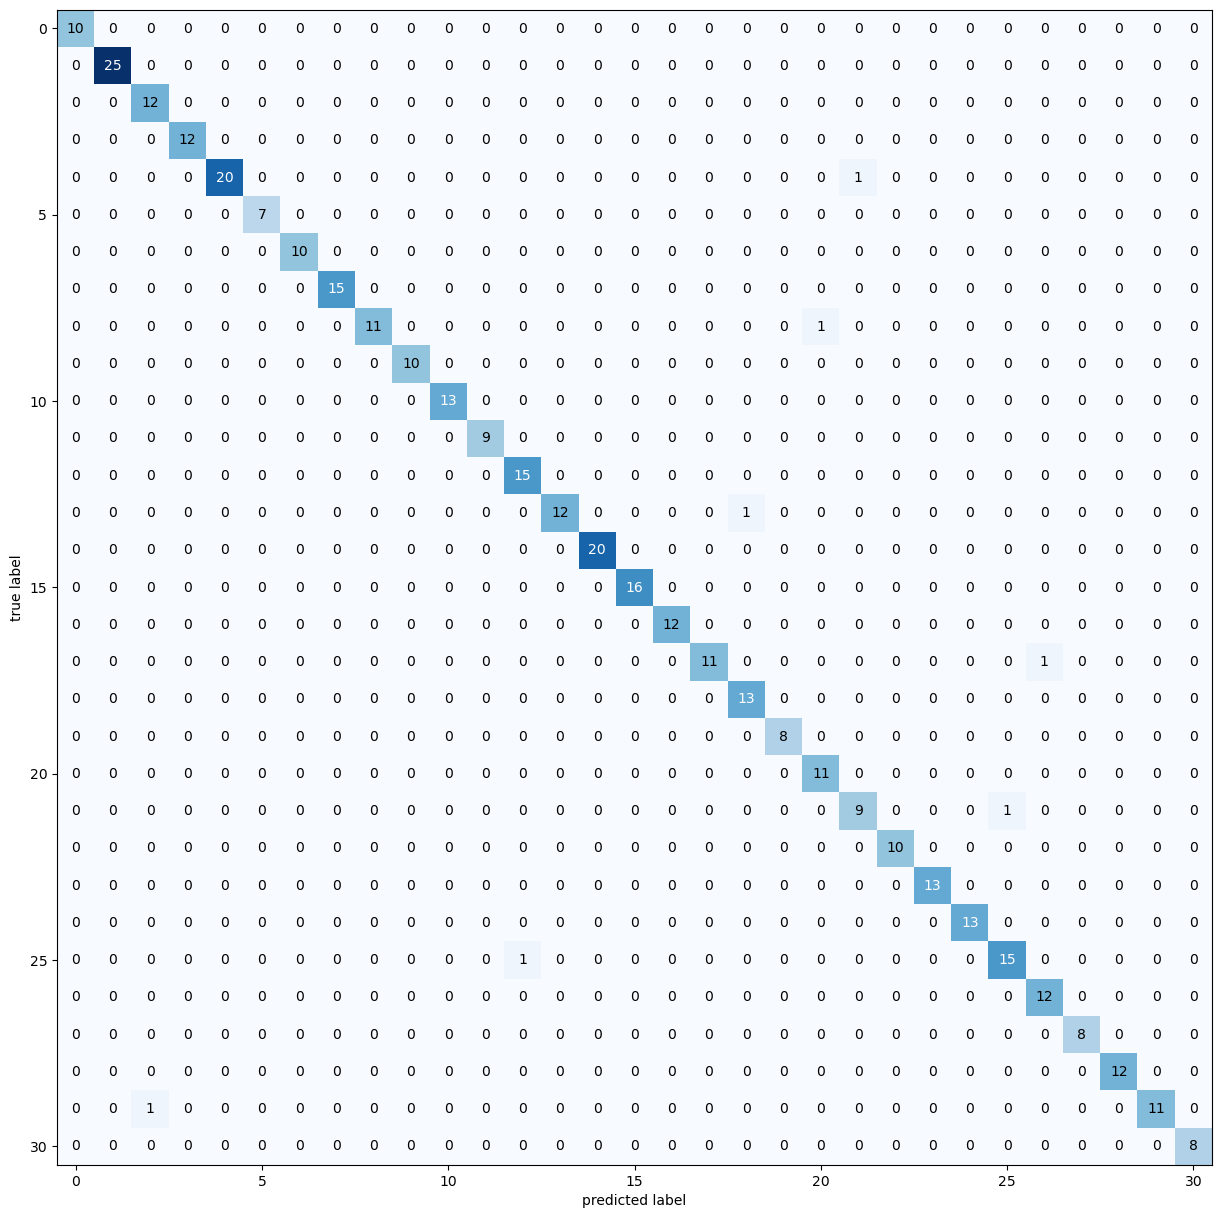

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       1.00      1.00      1.00        10
            Amaranthus Viridis (Arive-Dantu)       1.00      1.00      1.00        25
        Artocarpus Heterophyllus (Jackfruit)       0.92      1.00      0.96        12
                   Azadirachta Indica (Neem)       1.00      1.00      1.00        12
                       Basella Alba (Basale)       1.00      0.95      0.98        21
            Brassica Juncea (Indian Mustard)       1.00      1.00      1.00         7
                               carica papaya       1.00      1.00      1.00        10
                  Carissa Carandas (Karanda)       1.00      1.00      1.00        15
                        Citrus Limon (Lemon)       1.00      0.92      0.96        12
             Ficus Auriculata (Roxburgh fig)       1.00      1.00      1.00        10
               Ficus Religiosa (Peepal Tree)       1.

In [8]:
epoch=200
model_vgg16=vgg16(X_train, y_train, X_test, y_test, 'my_vgg16_smote.h5',epoch)

17225924/17225924 [==============================] - 1s 0us/step
Epoch 1/200
94/94 [==============================] - ETA: 0s - loss: 23.5905 - accuracy: 0.7981
Epoch 1: val_accuracy improved from -inf to 0.49487, saving model to ./Checkpoints/checkpoint_mobilenet
94/94 [==============================] - 22s 101ms/step - loss: 23.5905 - accuracy: 0.7981 - val_loss: 8.2389 - val_accuracy: 0.4949
Epoch 2/200
94/94 [==============================] - ETA: 0s - loss: 3.9821 - accuracy: 0.9714
Epoch 2: val_accuracy improved from 0.49487 to 0.82564, saving model to ./Checkpoints/checkpoint_mobilenet
94/94 [==============================] - 8s 86ms/step - loss: 3.9821 - accuracy: 0.9714 - val_loss: 2.7489 - val_accuracy: 0.8256
Epoch 3/200
94/94 [==============================] - ETA: 0s - loss: 1.8316 - accuracy: 0.9847
Epoch 3: val_accuracy improved from 0.82564 to 0.90513, saving model to ./Checkpoints/checkpoint_mobilenet
94/94 [==============================] - 8s 83ms/step - loss: 1.8316

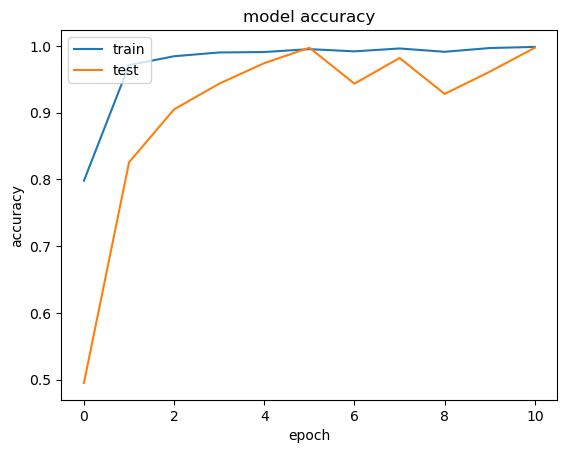

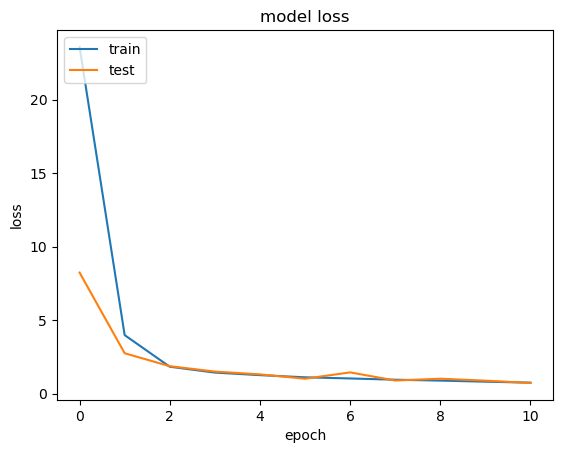

13/13 [==============================] - 1s 27ms/step


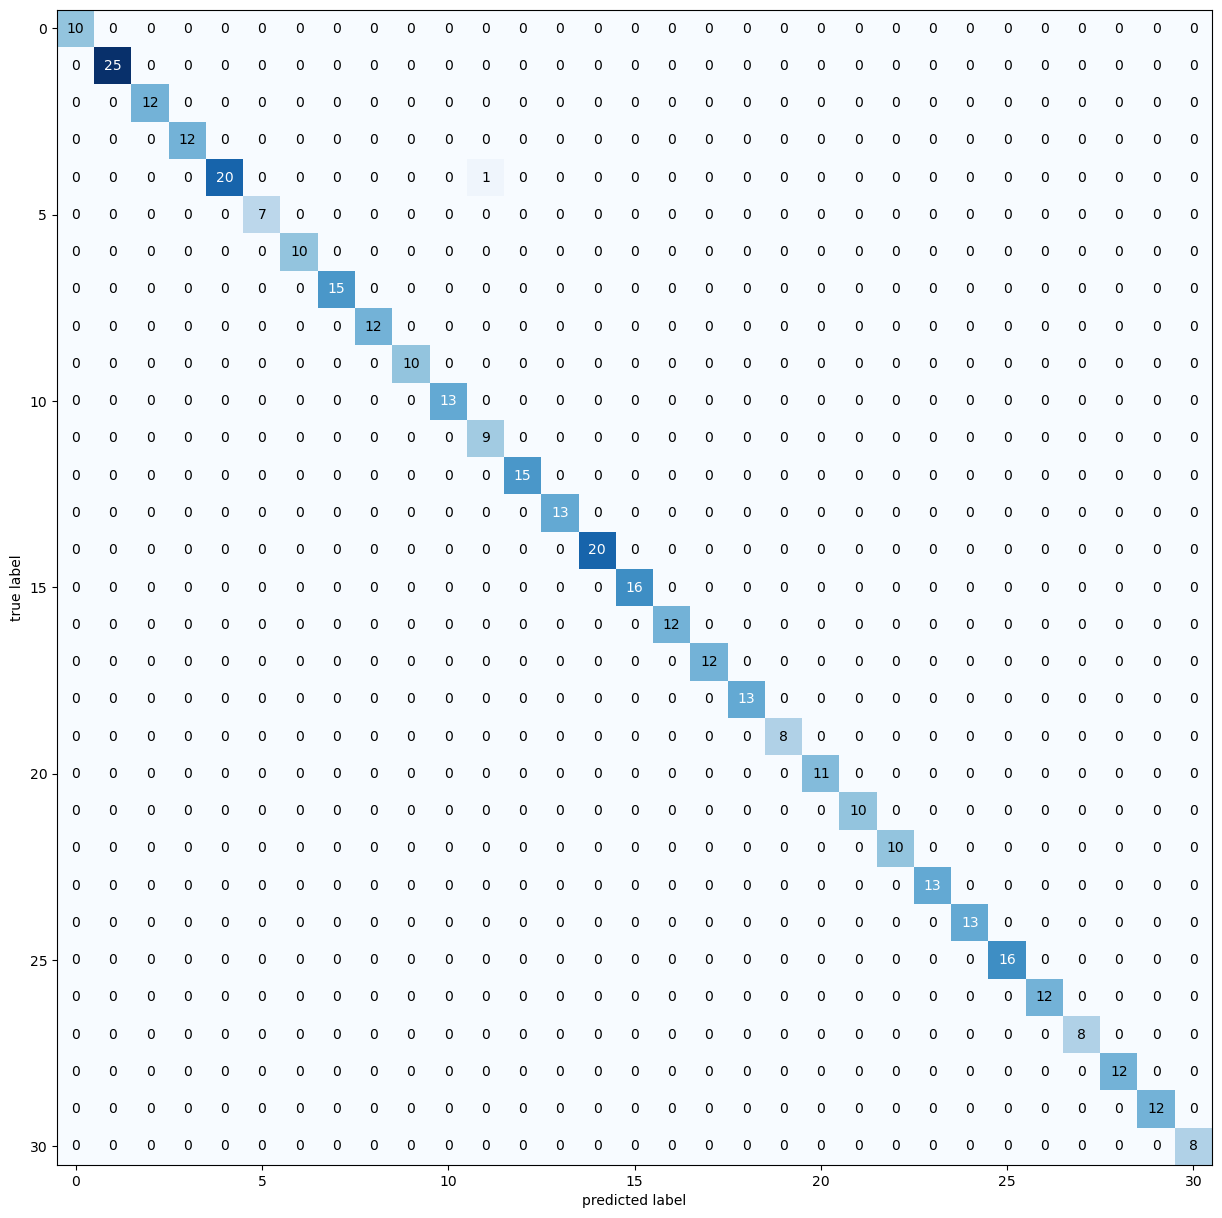

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       1.00      1.00      1.00        10
            Amaranthus Viridis (Arive-Dantu)       1.00      1.00      1.00        25
        Artocarpus Heterophyllus (Jackfruit)       1.00      1.00      1.00        12
                   Azadirachta Indica (Neem)       1.00      1.00      1.00        12
                       Basella Alba (Basale)       1.00      0.95      0.98        21
            Brassica Juncea (Indian Mustard)       1.00      1.00      1.00         7
                               carica papaya       1.00      1.00      1.00        10
                  Carissa Carandas (Karanda)       1.00      1.00      1.00        15
                        Citrus Limon (Lemon)       1.00      1.00      1.00        12
             Ficus Auriculata (Roxburgh fig)       1.00      1.00      1.00        10
               Ficus Religiosa (Peepal Tree)       1.

In [9]:
epoch=200
model_mobile=mobilenet(X_train, y_train, X_test, y_test, 'my_mobilenet_smote.h5',epoch)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

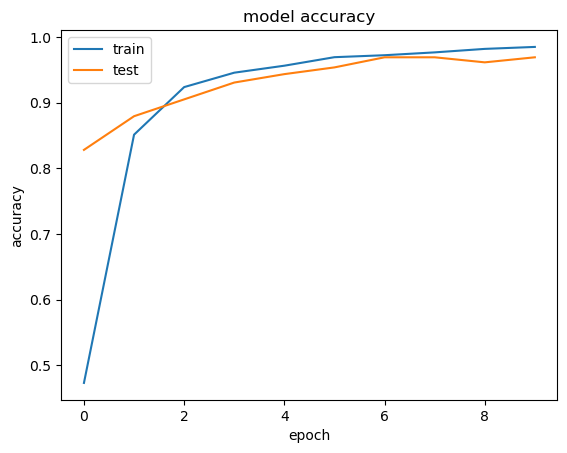

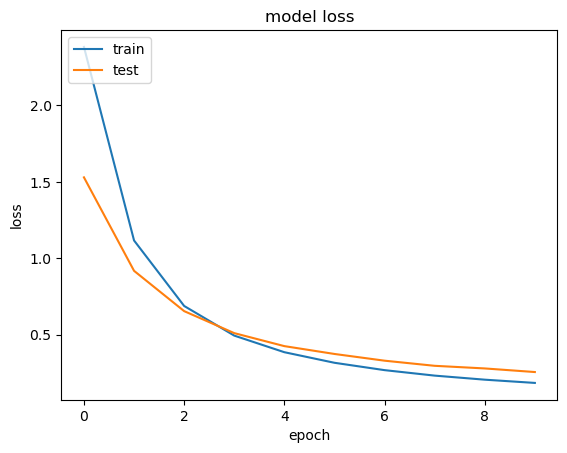

13/13 [==============================] - 1s 63ms/step


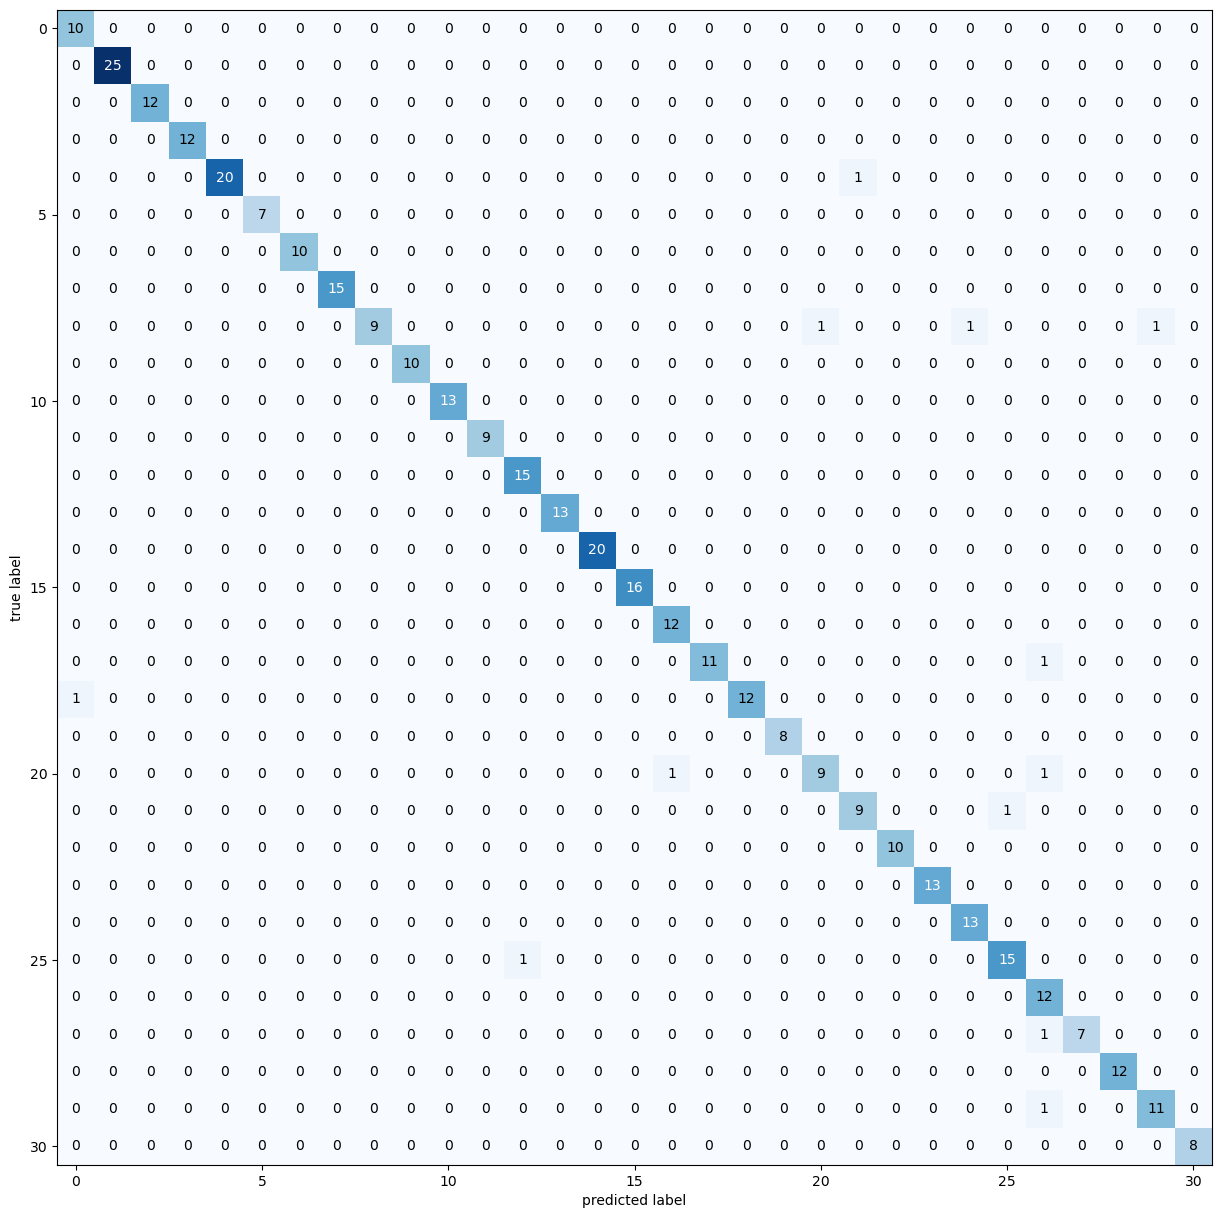

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       0.91      1.00      0.95        10
            Amaranthus Viridis (Arive-Dantu)       1.00      1.00      1.00        25
        Artocarpus Heterophyllus (Jackfruit)       1.00      1.00      1.00        12
                   Azadirachta Indica (Neem)       1.00      1.00      1.00        12
                       Basella Alba (Basale)       1.00      0.95      0.98        21
            Brassica Juncea (Indian Mustard)       1.00      1.00      1.00         7
                               carica papaya       1.00      1.00      1.00        10
                  Carissa Carandas (Karanda)       1.00      1.00      1.00        15
                        Citrus Limon (Lemon)       1.00      0.75      0.86        12
             Ficus Auriculata (Roxburgh fig)       1.00      1.00      1.00        10
               Ficus Religiosa (Peepal Tree)       1.

In [10]:
epoch=10
model_vgg16=vgg16(X_train, y_train, X_test, y_test, 'my_vgg16_smote.h5',epoch)

In [ ]:
def inception(X_train, y_train, X_test, y_test, modelname,epoch):
    from keras.applications.inception_v3 import InceptionV3
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=9, verbose=1, mode='max', restore_best_weights=True)

    checkpoint_filepath = './Checkpoints/checkpoint_inception'
    
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True)
    #inception
    a=224
    IMAGE_SIZE = [a, a]
    inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    for layer in inception.layers:
        layer.trainable = False


    x = Flatten()(inception.output)
    prediction = Dense(31, activation='softmax')(x)
    model = Model(inputs=inception.input, outputs=prediction)
    #model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    start_time = time.time()
    history = model.fit(X_train,y_train,validation_data=(X_test , y_test),epochs=epoch, verbose=1,callbacks=[earlystopping,model_checkpoint_callback])
    execution_time = (time.time() - start_time)/60.0
    print("Training execution time (mins)",execution_time)
    plot_graph(history)
    confusionmat(model)

    model.save(modelname)
    # Load the saved model
    model = load_model(modelname)
    return model


In [ ]:
epoch=100
model_inception=inception(X_train, y_train, X_test, y_test, 'my_inception_smote.h5',epoch)

In [ ]:
import gc
gc.collect()

In [ ]:
#epoch=10
#model_mobile=mobilenet(X_train, y_train, X_test, y_test, 'my_mobilenet_smote.h5',epoch)
#model=load_model('/kaggle/input/weightsfile/my_mobilenet_smote_keggle1.h5')
#confusionmat(model)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('best_weights_reg.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=9,verbose=1, mode='max', restore_best_weights=True)

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new output layers for the classification task
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='softmax')(x)
predictions = tf.keras.layers.Dense(31, activation='softmax')(x)

# Define the new model with the pre-trained layers from the base model and the new layers for classification
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
checkpoint = ModelCheckpoint('best_weights_reg.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=9,verbose=1, mode='max', restore_best_weights=True)

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new output layers for the classification task
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
predictions = tf.keras.layers.Dense(31, activation='softmax')(x)

# Define the new model with the pre-trained layers from the base model and the new layers for classification
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

#optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import gc
gc.collect()
history=model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test),callbacks=[earlystopping,checkpoint])

In [ ]:
confusionmat(model)

In [ ]:
plot_graph(history)

Epoch 1/200
301/301 [==============================] - ETA: 0s - loss: 2.6784 - accuracy: 0.2887
Epoch 1: val_accuracy improved from -inf to 0.04359, saving model to best_weights.h5
301/301 [==============================] - 15s 35ms/step - loss: 2.6784 - accuracy: 0.2887 - val_loss: 4.8107 - val_accuracy: 0.0436 - lr: 4.0000e-04
Epoch 2/200
299/301 [============================>.] - ETA: 0s - loss: 1.7388 - accuracy: 0.5930
Epoch 2: val_accuracy improved from 0.04359 to 0.56410, saving model to best_weights.h5
301/301 [==============================] - 9s 29ms/step - loss: 1.7383 - accuracy: 0.5926 - val_loss: 1.8372 - val_accuracy: 0.5641 - lr: 4.0000e-04
Epoch 3/200
299/301 [============================>.] - ETA: 0s - loss: 1.2013 - accuracy: 0.7344
Epoch 3: val_accuracy improved from 0.56410 to 0.57436, saving model to best_weights.h5
301/301 [==============================] - 9s 30ms/step - loss: 1.2010 - accuracy: 0.7346 - val_loss: 1.5955 - val_accuracy: 0.5744 - lr: 4.0000e-04


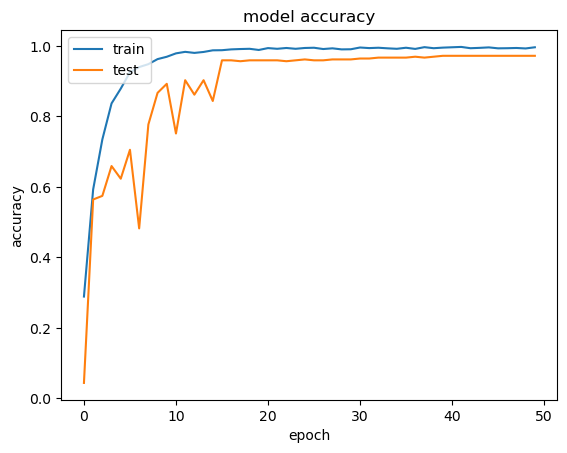

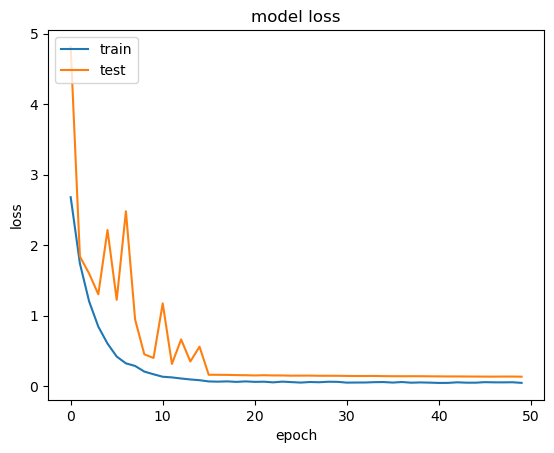

13/13 [==============================] - 1s 34ms/step


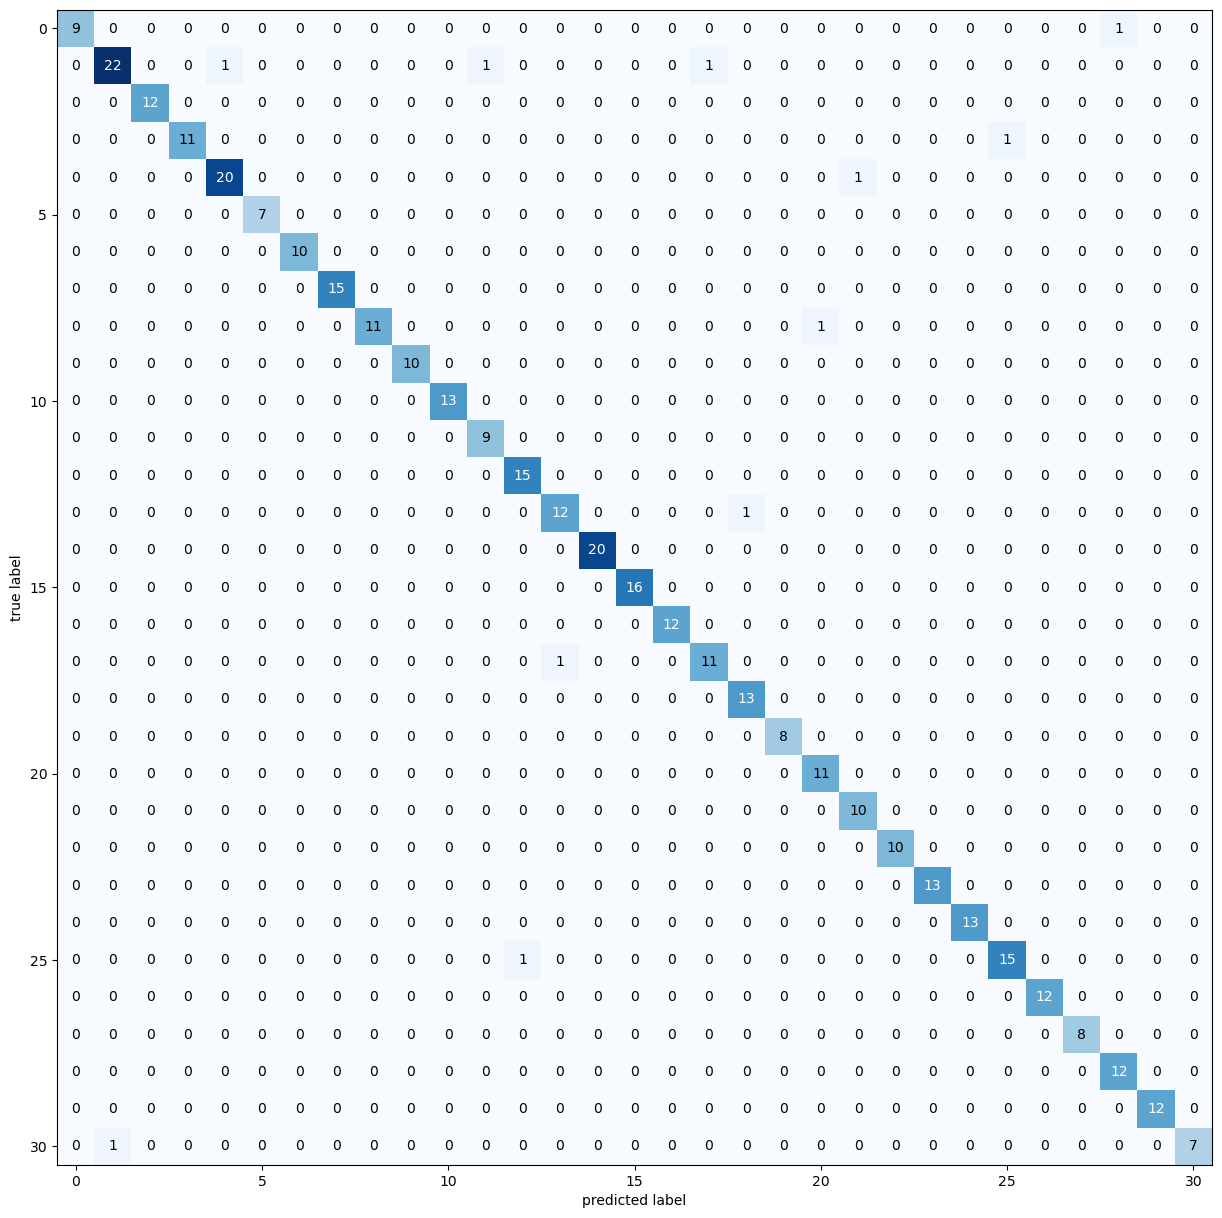

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       1.00      0.90      0.95        10
            Amaranthus Viridis (Arive-Dantu)       0.96      0.88      0.92        25
        Artocarpus Heterophyllus (Jackfruit)       1.00      1.00      1.00        12
                   Azadirachta Indica (Neem)       1.00      0.92      0.96        12
                       Basella Alba (Basale)       0.95      0.95      0.95        21
            Brassica Juncea (Indian Mustard)       1.00      1.00      1.00         7
                               carica papaya       1.00      1.00      1.00        10
                  Carissa Carandas (Karanda)       1.00      1.00      1.00        15
                        Citrus Limon (Lemon)       1.00      0.92      0.96        12
             Ficus Auriculata (Roxburgh fig)       1.00      1.00      1.00        10
               Ficus Religiosa (Peepal Tree)       1.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Layer
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold
from keras import regularizers

from tensorflow.keras import regularizers
checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10,verbose=1, mode='max', restore_best_weights=True)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model


from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.001, patience=3)

def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(31, activation='softmax'))
    return model
model = create_cnn_model()
from tensorflow.keras.optimizers import  RMSprop

optimizer = RMSprop(
         learning_rate=0.0004,
         momentum=0.1,
         epsilon=1e-8
     )
from tensorflow.keras.optimizers import  RMSprop

# optimizer = Adam(
#     learning_rate=0.1,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-8
# )


model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#history=model.fit(np.array(xtrain), np.array(ytrain), epochs=200, batch_size=8, validation_data=(np.array(xtest), np.array(ytest)),callbacks=[earlystopping,checkpoint,lr_scheduler])
history=model.fit(X_train,y_train, epochs=200, batch_size=10, validation_data=(X_test, y_test),callbacks=[earlystopping,checkpoint,lr_scheduler])
plot_graph(history)
confusionmat(model)